# Covermap Comparison

**Author:** Adam Yang (ayang115@umd.edu)

**Description:** Compares datasets against test sets

**Crop Maps Used:** Harvest Togo & Kenya, Copernicus Land Cover, ESA CCI Land Cover Africa, GLAD Global Cropland Extent

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import geemap
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt

from pathlib import Path
from shapely import wkt
from sklearn.metrics import classification_report 
from shapely.geometry import Point, MultiPolygon, GeometryCollection 


c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import ee

ee.Authenticate()

ee.Initialize()


Successfully saved authorization token.


### **Setup**

**Constants**

In [3]:
TEST_COUNTRIES = ["Kenya", "Togo", "Tanzania_CEO_2019"]
DATA_PATH = "../data/datasets/"
TEST_CODE = {"Kenya": "KEN", "Togo": "TGO", "Tanzania_CEO_2019": "TZA"} # for NE boundaries

In [4]:
DATASET_PATH = Path(DATA_PATH).glob("*")
TARGET_PATHS = [p for p in DATASET_PATH if p.stem in TEST_COUNTRIES] # test data path

In [5]:
# country boundaries
NE_GDF = gpd.read_file(
    shpreader.natural_earth(
        resolution='10m', 
        category='cultural', 
        name='admin_1_states_provinces')
)


**Functions**

In [6]:
# Remaps classes to crop/noncrop 
def map_values(val, value_for_crop):
    if val == value_for_crop:
        return 1
    else:
        return 0

In [7]:
# Function used in map function to extract from feature collection
def raster_extraction(image, resolution, f_collection):
    feature = image.sampleRegions(
        collection = f_collection,
        scale = resolution
    )
    return feature

In [8]:
# Convert sklearn classification report dict to 
def report_to_row(dataset, report, df):
    new_report = pd.DataFrame(data = {
        "dataset": dataset, 
        "accuracy": report["accuracy"], 
        "crop_f1": report["1"]["f1-score"], 
        "crop_support": report["1"]["support"], 
        "noncrop_support": report["0"]["support"], 
        "crop_precision": report["1"]["precision"], 
        "crop_recall": report["1"]["recall"], 
        "noncrop_precision": report["0"]["precision"], 
        "noncrop_recall": report["0"]["recall"]
        }, index=[0])
    
    return pd.concat([df, new_report])

In [9]:
# Creates ee.Feature from longitude and latitude coordinates from a dataframe
def create_point(row):
    geom = ee.Geometry.Point(row['lon'], row['lat'])
    prop = dict(row[['lon', 'lat', 'country', 'test_class']])

    return ee.Feature(geom, prop)


In [10]:
# filters out data in gdf that is not within country bounds 
def filter_by_bounds(country: str, gdf: gpd.GeoDataFrame):
    boundary = NE_GDF.loc[NE_GDF['adm1_code'].str.startswith(country), :].copy()

    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')

    boundary = GeometryCollection([x for x in boundary['geometry']])

    mask = gdf.within(boundary)
    filtered = gdf.loc[mask].copy()

    return filtered

### **Generate Test Data**

In [16]:
#create a testing geodataframe
def generate_test_data(target_paths: str):
    test_gdf = gpd.GeoDataFrame(
        columns=['lat', 'lon', 'country', 'test_class', 'geometry'], 
        crs = 'epsg:4326')

    test_set = []
    
    for p in target_paths:
        # Set dict key name
        key = p.stem

        # Read in data and extract test values and points 
        df = pd.read_csv(p)
        df = df.loc[df['subset'] == 'testing']
        df = df[['lat', 'lon', 'class_probability']]

        # Recast points as 1 or 0 (threshold = 0.5)
        df['test_class'] = df['class_probability'].apply(lambda x: 1 if x > 0.5 else 0)

        df['country'] = key

        #convert to geodataframe
        df = gpd.GeoDataFrame(
            df, 
            geometry=gpd.points_from_xy(df.lon, df.lat)
            )

        df = filter_by_bounds(TEST_CODE[key], df)

        test_set.append(df)

    return pd.concat(test_set)

In [17]:
# test_data = generate_test_data(TARGET_PATHS)

In [18]:
# test_data.to_csv('../../intercomparison-data/test_data.csv')

In [19]:
test_data = pd.read_csv("../../intercomparison-data/test_data.csv").drop("Unnamed: 0", axis=1)
test_data["geometry"] = test_data["geometry"].apply(wkt.loads)
test_data = gpd.GeoDataFrame(test_data)

In [20]:
test_data.set_crs("epsg:4326", inplace=True)

,lat,lon,class_probability,test_class,country,geometry
0,0.725122,34.386282,0.00,0,Kenya,POINT (34.38628 0.72512)
1,0.621939,34.466496,0.00,0,Kenya,POINT (34.46650 0.62194)
2,0.226497,34.054859,0.00,0,Kenya,POINT (34.05486 0.22650)
3,0.096834,33.951959,0.00,0,Kenya,POINT (33.95196 0.09683)
4,0.032072,33.968469,0.00,0,Kenya,POINT (33.96847 0.03207)
...,...,...,...,...,...,...
2648,6.472810,1.502436,0.75,1,Togo,POINT (1.50244 6.47281)
2649,11.037647,0.048311,1.00,1,Togo,POINT (0.04831 11.03765)
2650,9.011538,1.493877,0.00,0,Togo,POINT (1.49388 9.01154)
2651,9.138645,1.391047,0.00,0,Togo,POINT (1.39105 9.13864)


Plot test points

<AxesSubplot:>

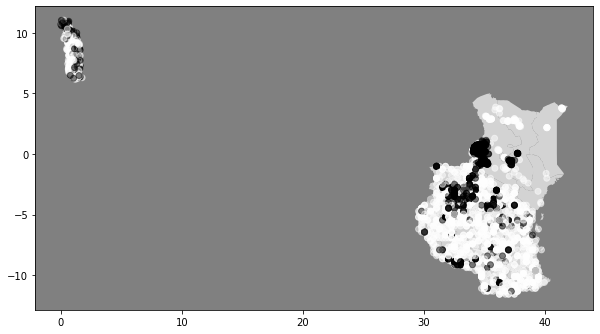

In [49]:
KEN_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("KEN")].copy()
TGO_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("TGO")].copy()
TZA_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("TZA")].copy()
masks = [KEN_mask, TZA_mask]

# Make sure the shapefile has EPSG:4326, otherwise convert it
for boundary in masks:
    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')
    boundary['roi'] = True
    boundary.reset_index(inplace=True, drop=True)
    boundary.dissolve('roi')

df = gpd.GeoDataFrame(pd.concat(masks)).set_crs('epsg:4326')

fig, ax = plt.subplots(figsize = (10,10))
ax.set_facecolor("gray")
df["geometry"].to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
test_data.plot(ax=ax, column='test_class', alpha=0.5, cmap='binary')

Support for each country

In [50]:
print(
    len(test_data[test_data['country']=='Togo']), 
    len(test_data[test_data['country']=='Kenya']), 
    len(test_data[test_data['country']=='Tanzania_CEO_2019'])
    )

352 764 1537


Assert no overlap

In [17]:
tgo = test_data.loc[test_data['country']=='Togo'].copy()
ken = test_data.loc[test_data['country']=='Kenya'].copy()
tan = test_data.loc[test_data['country']=='Tanzania_CEO_2019'].copy()

In [18]:
assert ~ken.overlaps(tan).all(), "Overlap detected!"
assert ~tan.overlaps(ken).all(), "Overlap detected!"

c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


Generate earth engine points

In [21]:
test_coll = ee.FeatureCollection(test_data.apply(create_point, axis=1).to_list())

In [20]:
test_data

,lat,lon,class_probability,test_class,country,geometry
0,0.725122,34.386282,0.00,0,Kenya,POINT (34.38628 0.72512)
1,0.621939,34.466496,0.00,0,Kenya,POINT (34.46650 0.62194)
2,0.226497,34.054859,0.00,0,Kenya,POINT (34.05486 0.22650)
3,0.096834,33.951959,0.00,0,Kenya,POINT (33.95196 0.09683)
4,0.032072,33.968469,0.00,0,Kenya,POINT (33.96847 0.03207)
...,...,...,...,...,...,...
2648,6.472810,1.502436,0.75,1,Togo,POINT (1.50244 6.47281)
2649,11.037647,0.048311,1.00,1,Togo,POINT (0.04831 11.03765)
2650,9.011538,1.493877,0.00,0,Togo,POINT (1.49388 9.01154)
2651,9.138645,1.391047,0.00,0,Togo,POINT (1.39105 9.13864)


In [21]:
pos = test_coll.filter("test_class == 1")
neg = test_coll.filter("test_class == 0")

In [22]:
import geemap.colormaps as cm
Map = geemap.Map(center=[8.7, 34.5], zoom=4)
pallete = cm.palettes.dem
vis_params = {'min': 0, 'max': 1, 'palette': pallete}

Map.addLayer(pos, {'color': 'FFFFFF'})
Map.addLayer(neg, {'color': '000000'})

# Map

**Create dataframe for results**

In [23]:
results = {}

for p in TARGET_PATHS:
    key = p.stem
    results[key] = pd.DataFrame(columns=["dataset", "accuracy", "crop_f1", "crop_support", "noncrop_support", 
        "crop_precision", "crop_recall", "noncrop_precision", "noncrop_recall"])


### **Harvest Data**

In [56]:
HARVEST_PATHS = [
    "projects/sat-io/open-datasets/nasa-harvest/togo_cropland_binary", 
    "projects/sat-io/open-datasets/nasa-harvest/kenya_cropland_binary",
    "users/adadebay/Tanzania_cropland_2019"]

In [59]:
harvest = []
for map in HARVEST_PATHS:
    name = map.split('/')[-1]
    print(name)

    #sample from earth engine
    sampled = ee.Image(map).sampleRegions(
        collection=test_coll,
        projection='epsg:4326',
        geometries=True
    )
    
    #convert to dataframe
    sampled = geemap.ee_to_gdf(sampled)
    
    #binarize 
    sampled["b1"] = sampled["b1"].apply(lambda x: 1 if x>0.5 else 0) 

    harvest.append(sampled)

harvest = pd.concat(harvest)

togo_cropland_binary
kenya_cropland_binary
Tanzania_cropland_2019


Show difference in sampling

In [26]:
test = test_data[['lat', 'lon', 'test_class', 'country']].copy()
har = harvest[['lat', 'lon', 'test_class', 'country']].copy()

In [27]:
har.reset_index(drop=True, inplace=True)

In [28]:
diff = test[~test.apply(tuple,1).isin(har.apply(tuple,1))]
diff = gpd.GeoDataFrame(diff, crs='epsg:4326', geometry=gpd.points_from_xy(diff.lon, diff.lat))
len(diff)

71

<AxesSubplot:>

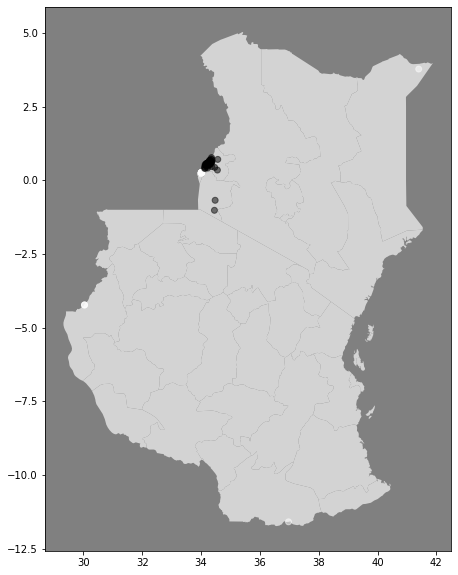

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor("gray")
df["geometry"].to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
diff.plot(ax=ax, column='test_class', alpha=0.5, cmap='binary')

In [30]:
# harvest.to_csv('../../intercomparison-data/harvest.csv')

Join test and sampled sets

In [31]:
test_data["harvest"] = pd.merge(test_data, harvest, on=["lat", "lon"], how="left")["b1"]

In [32]:
test_data

,lat,lon,class_probability,test_class,country,geometry,harvest
0,0.725122,34.386282,0.00,0,Kenya,POINT (34.38628 0.72512),1.0
1,0.621939,34.466496,0.00,0,Kenya,POINT (34.46650 0.62194),1.0
2,0.226497,34.054859,0.00,0,Kenya,POINT (34.05486 0.22650),0.0
3,0.096834,33.951959,0.00,0,Kenya,POINT (33.95196 0.09683),0.0
4,0.032072,33.968469,0.00,0,Kenya,POINT (33.96847 0.03207),0.0
...,...,...,...,...,...,...,...
2648,6.472810,1.502436,0.75,1,Togo,POINT (1.50244 6.47281),1.0
2649,11.037647,0.048311,1.00,1,Togo,POINT (0.04831 11.03765),1.0
2650,9.011538,1.493877,0.00,0,Togo,POINT (1.49388 9.01154),0.0
2651,9.138645,1.391047,0.00,0,Togo,POINT (1.39105 9.13864),0.0


### **COP, ESA, GLAD**

In [33]:
# Load copernicus data
copernicus = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global")

In [43]:
cop_results = copernicus.select(
    "discrete_classification").filterDate(
        "2019-01-01", "2020-01-01").map(
            lambda x: raster_extraction(x, 100, test_coll)).flatten()

cop_sampled = geemap.ee_to_gdf(cop_results)
cop_sampled["cop_class"] = cop_sampled["discrete_classification"].apply(lambda x: 1 if x==40 else 0)
cop_sampled.head()

,geometry,country,discrete_classification,lat,lon,test_class,cop_class
0,None,Kenya,126,0.725122,34.386282,0,0
1,None,Kenya,122,0.621939,34.466496,0,0
2,None,Kenya,40,0.226497,34.054859,0,1
3,None,Kenya,20,0.096834,33.951959,0,0
4,None,Kenya,80,0.032072,33.968469,0,0


In [35]:
assert (np.sort(cop_sampled[['lat', 'lon']]) == np.sort(test_data[['lat','lon']])).all(), "Point mismatch!"

In [36]:
test_data["cop"] = pd.merge(test_data, cop_sampled, on=["lat", "lon"], how="left")["cop_class"]

In [40]:
esa = ee.ImageCollection("ESA/WorldCover/v100")
esa_results = esa.filterBounds(test_coll).map(lambda x: raster_extraction(x, 10, test_coll)).flatten()
esa_sampled = geemap.ee_to_gdf(esa_results)
esa_sampled["esa_class"] = esa_sampled["Map"].apply(lambda x: 1 if x==40 else 0)
esa_sampled.head()

,geometry,Map,country,lat,lon,test_class,esa_class
0,None,20,Kenya,0.725122,34.386282,0,0
1,None,20,Kenya,0.621939,34.466496,0,0
2,None,30,Kenya,0.226497,34.054859,0,0
3,None,30,Kenya,0.096834,33.951959,0,0
4,None,80,Kenya,0.032072,33.968469,0,0


In [41]:
assert (np.sort(esa_sampled[['lat', 'lon']]) == np.sort(test_data[['lat','lon']])).all(), "Point mismatch!"

In [42]:
test_data["esa"] = pd.merge(test_data, esa_sampled, on=["lat", "lon"], how="left")["esa_class"]

In [44]:
glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019")
glad_results = glad.filterBounds(test_coll).map(lambda x: raster_extraction(x, 30, test_coll)).flatten()
glad_sampled = geemap.ee_to_gdf(glad_results)
glad_sampled.head()

,geometry,b1,country,lat,lon,test_class
0,None,1,Kenya,0.725122,34.386282,0
1,None,0,Kenya,0.621939,34.466496,0
2,None,0,Kenya,0.226497,34.054859,0
3,None,0,Kenya,0.096834,33.951959,0
4,None,0,Kenya,0.032072,33.968469,0


In [45]:
glad_diff = glad_sampled[['lat', 'lon']].compare(test_data[['lat','lon']])

In [46]:
glad_diff

lat                   lon           
          self      other       self      other
76    0.206487  -0.698091  35.004402  34.215673
77    0.064104  -4.104944  34.732424  39.648091
78    0.869092  -4.000159  35.486988  39.625765
79    1.300039  -1.237275  35.823250  37.563808
80    3.876416   0.206487  35.913137  35.004402
...        ...        ...        ...        ...
2648 -2.998368   6.472810  35.976357   1.502436
2649 -2.996376  11.037647  35.982109   0.048311
2650 -2.998963   9.011538  35.979944   1.493877
2651 -2.997940   9.138645  35.984116   1.391047
2652 -4.968315   9.186742  34.494156   1.344951

[2577 rows x 4 columns]

In [47]:
test_data['glad'] = pd.merge(test_data, glad_sampled, on=["lat", "lon"], how="left")["b1"]

In [48]:
test_data.to_csv('test.csv')

## **Evaluation Results**

**Compute results**

In [49]:
for country, df in test_data.groupby("country"):
    for dataset in ["cop", "esa", "glad", 'harvest']:
        print(country + ": " + dataset)
        # Remove na values
        temp = df[["test_class", dataset]].dropna()
        report = classification_report(temp["test_class"], temp[dataset], output_dict= True)     

        results[country] = report_to_row(dataset, report, results[country])

Kenya: cop
Kenya: esa
Kenya: glad
Kenya: harvest
Tanzania_CEO_2019: cop
Tanzania_CEO_2019: esa
Tanzania_CEO_2019: glad
Tanzania_CEO_2019: harvest
Togo: cop
Togo: esa
Togo: glad
Togo: harvest


**Kenya**

In [50]:
results["Kenya"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,cop,0.908377,0.939446,571,193,0.928205,0.950963,0.843575,0.782383
0,esa,0.403141,0.341040,571,193,0.975207,0.206655,0.295490,0.984456
0,glad,0.839005,0.887259,571,193,0.930769,0.847636,0.643443,0.813472
0,harvest,0.952654,0.968054,520,177,0.974659,0.961538,0.891304,0.926554


**Togo**

In [51]:
results["Togo"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,cop,0.730114,0.541063,107,245,0.560000,0.523364,0.797619,0.820408
0,esa,0.792614,0.613757,107,245,0.707317,0.542056,0.818519,0.902041
0,glad,0.781250,0.596859,107,245,0.678571,0.532710,0.813433,0.889796
0,harvest,0.747159,0.659004,107,245,0.558442,0.803738,0.893939,0.722449


**Tanzania**

In [52]:
results["Tanzania_CEO_2019"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,cop,0.782694,0.651357,431,1106,0.592030,0.723898,0.882178,0.805606
0,esa,0.824984,0.706652,431,1106,0.666667,0.751740,0.898192,0.853526
0,glad,0.797007,0.647856,431,1106,0.630769,0.665893,0.866913,0.848101
0,harvest,0.784736,0.644397,431,1102,0.601610,0.693735,0.872587,0.820327


## ***TESTING ZONE***

Codes of interest:
* Kenya : KEN
* Togo: TGO
* Tanzania: TZA

In [86]:
import rasterio as rio
from rasterio.plot import show
import pandas as pd

In [115]:
ras = rio.open("../../harvest-maps/Harvest_Togo_Binary.tif", 'r')
test = pd.read_csv("../data/datasets/Togo.csv")

test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat), crs='epsg:4326')
test = test.loc[test['subset']=='testing']
test['binary'] = test['class_probability'].apply(lambda x: 1 if x >= 0.5 else 0)


In [116]:
test.head()

,lon,lat,start_date,end_date,source,class_probability,num_labelers,subset,analysis_duration,email,country,dataset,eo_data,eo_lon,eo_lat,eo_file,eo_status,geometry,binary
1276,1.172471,9.875907,2019-01-01,2020-12-31,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,5,testing,NaN,NaN,Togo,Togo,"[[-14.830639001130564, -21.41569953197798, 127...",1.172436,9.875943,min_lat=9.8752_min_lon=1.1717_max_lat=9.8766_m...,eo_data_complete,POINT (1.17247 9.87591),0
1277,1.374695,9.180105,2019-01-01,2020-12-31,"random_sample_hrk,random_sample_cn,BB_random_s...",0.25,5,testing,NaN,NaN,Togo,Togo,"[[-10.125282616705093, -18.974100140490147, 11...",1.374737,9.180108,min_lat=9.1794_min_lon=1.374_max_lat=9.1808_ma...,eo_data_complete,POINT (1.37469 9.18011),0
1278,1.196385,9.275314,2019-01-01,2020-12-31,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,5,testing,NaN,NaN,Togo,Togo,"[[-7.471514396510763, -13.638469883967932, 116...",1.196421,9.275330,min_lat=9.2746_min_lon=1.1957_max_lat=9.276_ma...,eo_data_complete,POINT (1.19639 9.27531),0
1279,0.705167,7.346575,2019-01-01,2020-12-31,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,5,testing,NaN,NaN,Togo,Togo,"[[-7.473177435466951, -13.969861171679964, 106...",0.705133,7.346557,min_lat=7.3459_min_lon=0.7044_max_lat=7.3473_m...,eo_data_complete,POINT (0.70517 7.34658),0
1280,0.629817,6.777337,2019-01-01,2020-12-31,"random_sample_hrk,random_sample_cn,BB_random_s...",0.25,5,testing,NaN,NaN,Togo,Togo,"[[-7.924904168593527, -14.50019807859041, 1200...",0.629854,6.777295,min_lat=6.7766_min_lon=0.6291_max_lat=6.7781_m...,eo_data_complete,POINT (0.62982 6.77734),0


In [129]:

def create_point2(row):
    geom = ee.Geometry.Point(row.lon, row.lat)
    prop = dict(row[['binary']])

    return ee.Feature(geom, prop)

proj_coll = ee.FeatureCollection(test.apply(create_point2, axis=1).to_list())

In [130]:
togo = ee.Image("projects/sat-io/open-datasets/nasa-harvest/togo_cropland_binary")

In [136]:
togo = togo.reproject(crs='epsg:4326', scale=10)

In [137]:
sampled = ee.Image(togo).sampleRegions(
        collection=proj_coll,
        geometries=True
    )
sampled = geemap.ee_to_gdf(sampled)


In [138]:
sampled

,geometry,b1,binary
0,POINT (1.17244 9.87594),0,0
1,POINT (1.37474 9.18011),0,0
2,POINT (1.19642 9.27533),0,0
3,POINT (0.70513 7.34656),0,0
4,POINT (0.62985 6.77729),0,0
...,...,...,...
350,POINT (1.50248 6.47277),1,1
351,POINT (0.04828 11.03764),1,1
352,POINT (1.49385 9.01149),0,0
353,POINT (1.39109 9.13861),0,0


In [139]:
report = classification_report(test['binary'], sampled['b1'], output_dict=True)
res = pd.DataFrame(data = { 
        "accuracy": report["accuracy"], 
        "crop_f1": report["1"]["f1-score"], 
        "crop_support": report["1"]["support"], 
        "noncrop_support": report["0"]["support"], 
        "crop_precision": report["1"]["precision"], 
        "crop_recall": report["1"]["recall"], 
        "noncrop_precision": report["0"]["precision"], 
        "noncrop_recall": report["0"]["recall"]
        }, index=[0])

In [140]:
res

,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,0.780282,0.745098,152,203,0.74026,0.75,0.810945,0.802956
